In [132]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

###  Part 1 - Exploratory Data Analysis
First we open the 'logins.json' file and read it as a Pandas dataframe. 

In [2]:
with open('logins.json', 'r') as file:
   data = json.load(file)
df_logins = pd.DataFrame(data)
df_logins.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


The timestamps are out of order. They need to be sorted for further analysis.

In [3]:
# The timestamps are out of order (rows 0 and 6 for example)
df_logins['login_time'] = df_logins.login_time.sort_values()
df_logins.head(10)

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
5,1970-01-01 20:21:41
6,1970-01-01 20:12:16
7,1970-01-01 20:35:47
8,1970-01-01 20:35:38
9,1970-01-01 20:47:52


We should see how many rows it has, as well the timespan of this data.

In [4]:
# This column has approximately 3 months worth of data 

print(min(df_logins.login_time))
print(max(df_logins.login_time))

1970-01-01 20:12:16
1970-04-13 18:57:38


In [5]:
df_logins.dtypes

login_time    object
dtype: object

The dates can be easily manipulated and aggregated if we switch its type to datetime objects

In [6]:
df_logins['login_time'] = pd.to_datetime(df_logins['login_time'])

In [9]:
df_logins.set_index('login_time').sort_index().resample('15T').size().head(10)

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
1970-01-01 21:15:00    4
1970-01-01 21:30:00    0
1970-01-01 21:45:00    4
1970-01-01 22:00:00    9
1970-01-01 22:15:00    8
Freq: 15T, dtype: int64

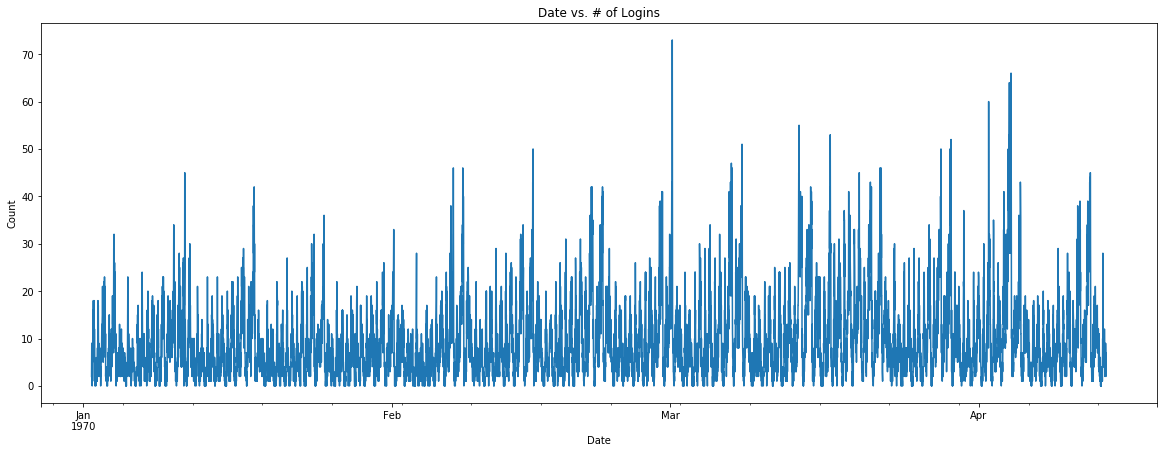

In [10]:
# Data visualization
plt.figure(figsize=(20, 7))
df_logins.set_index('login_time').sort_index().resample('15T').size().plot()
plt.title('Date vs. # of Logins')
plt.xlabel('Date')
plt.ylabel('Count');


Plotting the date with the number of logins, it shows four cycles (and peaks) occuring every month, likely implying that a high volume of logins occur on the weekend. There also appears to be a very slight increase of mean of counts as the year goes on.  

In [59]:
# Initial look at the ultimate data

with open('ultimate_data_challenge.json', 'r') as file:
   data = json.load(file)
df_ultimate = pd.DataFrame(data)
print(df_ultimate.shape)
df_ultimate.head()

(50000, 12)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


### Part 2 ‐ Experiment and metrics design

#### 1.

I would choose time stamps showing up on both cities within a time interval as a key measure of success. The higher this value, the higher the number of driver partners willing to go to both cities. 

### 2a.

Assuming we already have data on timestamps under the normal two-way toll conditions, I would begin the reimbursement program for a set period of time and then collect data of the timestamps under those new conditions. This will allow me to have two samples generated under both conditions which I want to compare.

### 2b. 

I would conduct a **t-test for comparing means** to see if the sample under the reimbursement conditions has a statistically significant higher mean of timestamps in both locations within a defined time interval, as defined by a p-value threshold. 

### 2c. 

I would recommend continuing or halting the reimbursement program based on the results from the proposed experiment. If the the mean of the sample from the reimbursement program is statistically and significantly higher then that from the original conditions, I would say continue the program. Otherwise, halt it. 

Success of the program, that is, how much higher of a mean the reimbursement program induces, would have to be established among the city managers. It is also important to consider the baseline trends that might be seen regardless of this implementation, so as to not incorrectly correlate any trends with   

### Part 3 ‐ Predictive modeling

#### 1. 

The fraction of observed users can be found by looking into the 'trips_in_first_30_days' column, dividing the instances a value there equals 0 by the total number of existing instances.

In [66]:
# The trips_in_first_30_days feature has no missing values 
df_ultimate.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [67]:
df_ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [68]:
# We consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 
# Therefore, the rows where 'trips_in_first_30_days' equals 0 would be considered NOT retained.

notrips = df_ultimate[df_ultimate['trips_in_first_30_days']==0]['trips_in_first_30_days'].count()
notrips

15390

In [69]:
retained = notrips/len(df_ultimate['trips_in_first_30_days'])
retained

0.3078

About 30.78% of observed users were retained. 

Only three columns have missing values, 'avg_rating_by_driver', 'avg_rating_of_driver', and 'phone'. The clients may be less inclined than the drivers to give their ratings. Also, some users may have phones that are neither iPhones nor Androids. It would be reasonable to fill the NaNs in the phone column with 'Other'.

In [70]:
df_ultimate['phone'].fillna('Other', inplace=True)
df_ultimate['phone'].value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

We can then remove all rows with missing values on 'avg_rating_by_driver' or 'avg_rating_of_driver', as well as dropping potential duplicate rows

In [71]:
df_ultimate.dropna(inplace=True)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [72]:
# Drop any potential duplicate rows
df_ultimate.drop_duplicates(inplace=True)

In [73]:
#41744 rows, 12 columns 
df_ultimate.shape

(41739, 12)

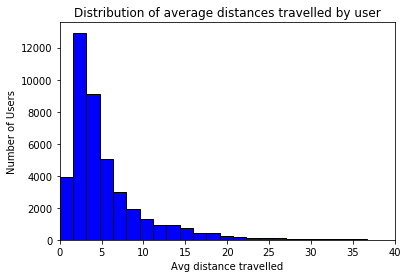

In [74]:
plt.hist(df_ultimate['avg_dist'], color = 'blue', edgecolor = 'black',
         bins = int(250/5));
plt.xlim(0,40);
plt.title('Distribution of average distances travelled by user')
plt.xlabel('Avg distance travelled')
plt.ylabel('Number of Users');

Here we see a large portion of users travelling less than 10 units. It would be interesting to get an exact statistic of this

In [75]:
df_ultimate[df_ultimate['avg_dist'] <= 10].count()[0]

36343

In [76]:
# 87.1% of users travelled less than 10 units
df_ultimate[df_ultimate['avg_dist'] <= 10].count()[0]/df_ultimate.shape[0]

0.870720429334675

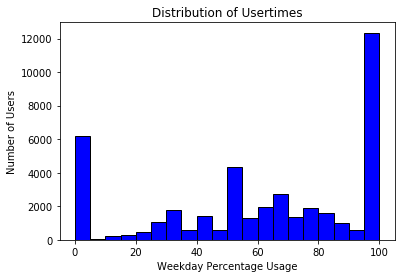

In [77]:
plt.hist(df_ultimate['weekday_pct'], color = 'blue', edgecolor = 'black',
         bins = int(100/5));
plt.title('Distribution of Usertimes')
plt.xlabel('Weekday Percentage Usage')
plt.ylabel('Number of Users');

In [78]:
weekendsonly = df_ultimate[df_ultimate['weekday_pct'] == 0]['weekday_pct'].count()
weekdaysonly = df_ultimate[df_ultimate['weekday_pct'] == 100]['weekday_pct'].count()
print(weekendsonly)
print(weekdaysonly)
print(weekendsonly + weekdaysonly)

6198
12184
18382


In [79]:
df_ultimate['city'].unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

Other statistics gathered by EDA:
- The average ratings by driver and of driver are fairly high: 4.78 and 4.60 respectively
- By filling and removing rows with missing values appropriately, we are able to retain 41744/50000 = approx. 83% of our data
- The cities travelled to by users are King's Landing, Astapor, and Winterfell
- 36343/41445 = 87% of users travelled less than or equal to 10 units
- 6198/41445 = 15% of users only travel during the weekends
- 12184/41445 = 29% of users ony travel during the weekdays

#### 2. 


In [84]:
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In order to build a model that predicts a user's activity in the 6th month, we can create a column, 'nb_months', that states the maximum number of months this user was active. Here, any user that shows activity over 5 months can be considered active in their 6th month. From the 'nb_months' column, we can create another binary column that contains a value of 0 for users with 'nb_months' values less than 5, else value of 1. To reduce redundancy, the 'last_trip_date', 'signup_date', and 'nb_months'columns can then be removed.

In [85]:
df_ultimate['last_trip_date'] = pd.to_datetime(df_ultimate['last_trip_date'])
df_ultimate['signup_date'] = pd.to_datetime(df_ultimate['signup_date'])

In [87]:
df_ultimate['nb_months'] = (df_ultimate.last_trip_date - df_ultimate.signup_date)/np.timedelta64(1, 'M')
df_ultimate['active'] = np.where(df_ultimate['nb_months']>5,1,0)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,nb_months,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,4.698248,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,3.154069,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.032855,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,5.585330,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1.544180,0


In [88]:
df_ultimate.drop(['last_trip_date','signup_date','nb_months'], axis=1, inplace=True)
df_ultimate

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,False,82.4,0
5,10.56,5.0,3.5,1.00,Winterfell,iPhone,0.0,2,True,100.0,0
7,2.04,5.0,5.0,1.00,Winterfell,iPhone,0.0,2,False,100.0,0
8,4.36,5.0,4.5,1.00,Winterfell,Android,0.0,2,False,100.0,0
10,4.28,4.9,5.0,1.00,Winterfell,iPhone,0.0,1,True,100.0,0
11,3.81,5.0,4.0,1.00,Winterfell,iPhone,0.0,3,False,100.0,0


The next step of preprocessing is to convert the boolean ('ultimate_black_user') and categorical columns ('city','phone') into numerical columns.

In [89]:
# Turn the Boolean series, 'ultimate_black_user', into 0s and 1s
df_ultimate['ultimate_black_user'] *= 1
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,15.4,4,1,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,Android,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,Android,11.8,14,0,82.4,0


In [90]:
# Convert the categorical variables into numerical variables with get_dummies 
df_ultimate = pd.get_dummies(df_ultimate)
df_ultimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,3.67,5.0,4.7,1.10,15.4,4,1,46.2,0,0,1,0,0,0,1
1,8.26,5.0,5.0,1.00,0.0,0,0,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,0.0,3,0,100.0,0,1,0,0,0,0,1
3,2.36,4.9,4.6,1.14,20.0,9,1,80.0,1,0,1,0,0,0,1
4,3.13,4.9,4.4,1.19,11.8,14,0,82.4,0,0,0,1,1,0,0


With the dataframe fully set up for machine learning, I set up my X and y, created the train and test sets, and made a function, train_and_test_model that can implement many types of models with optimized hyperparameters and metrics found through GridSearchCV. The key indicators I used to determine model performance were accuracy and area under the ROC curve(AUC_ROC). The classes I aimed to predict in this dataset are fairly imbalanced as seen below, so monitoring the AUC_ROC serves to validate that the model can appropriately distinguish between classes. The models I tried out are Logistic Regression, K-Nearest Neighbors, Desicion Trees, and Random Forests. 

In [129]:
active_pct = len([i for i in y if i ==1])/len(y)
print("%0.2f percent of users were active in their 6th month" % (active_pct*100))

24.95 percent of users were active in their 6th month


In [91]:
# Set up X and y
X = df_ultimate.drop('active',axis = 1)
y = df_ultimate['active']

In [96]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [115]:
# Make a function that testsout multiple models

def train_and_test_model(X, y, model, param_grid):
    '''Takes in a dataframe and prarmeter grid, splits the data, 
    and optimizes the hyperparameters for the best score through
    a grid search.
    '''
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    
    # Instantiate the GridSearchCV object: model_cv
    model_cv = GridSearchCV(model, param_grid=param_grid, cv=5)
    
    # Fit the model to the training data
    model_cv.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = model_cv.predict(X_test)
    
    # This will be useful for creating our ROC curves 
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show();
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))

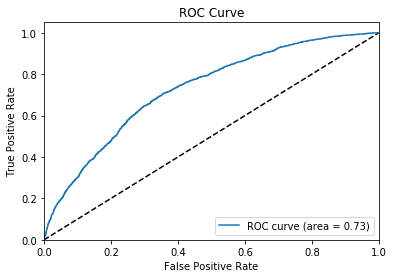

Tuned Hyperparameter(s): {'C': 1274274.985703132, 'penalty': 'l1'}
Tuned Accuracy Score: 0.7591267107903327
             precision    recall  f1-score   support

          0       0.78      0.96      0.86      6301
          1       0.60      0.17      0.26      2047

avg / total       0.74      0.77      0.71      8348



In [116]:
# Simple Logistic Regression Model

logreg = LogisticRegression()
c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possible C values
logreg_param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

train_and_test_model(X,y,logreg,logreg_param_grid)

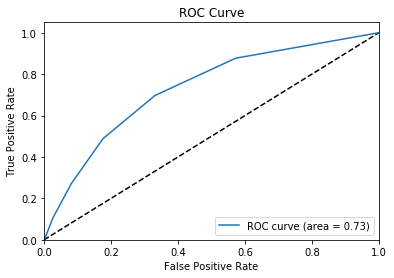

Tuned Hyperparameter(s): {'n_neighbors': 6}
Tuned Accuracy Score: 0.7564014255338265
             precision    recall  f1-score   support

          0       0.80      0.92      0.85      6301
          1       0.52      0.27      0.36      2047

avg / total       0.73      0.76      0.73      8348



In [117]:
# Simple K-Nearest Neighbors Model

knn = KNeighborsClassifier()
N = [1,2,3,4,5,6,7]
knn_param_grid = {'n_neighbors': N}
train_and_test_model(X, y, knn, knn_param_grid)

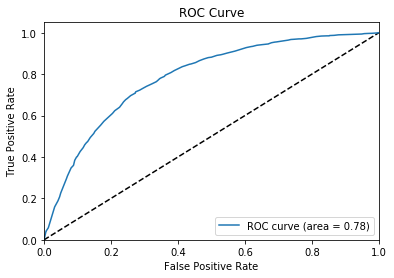

Tuned Hyperparameter(s): {'max_depth': 9, 'min_samples_split': 490}
Tuned Accuracy Score: 0.7785031894821958
             precision    recall  f1-score   support

          0       0.81      0.91      0.86      6301
          1       0.57      0.36      0.44      2047

avg / total       0.75      0.78      0.76      8348



In [118]:
# Simple Desicion Tree Model

tree = DecisionTreeClassifier()
tree_param_grid = {'min_samples_split': range(10,500,20),'max_depth': range(1,20,2)}
train_and_test_model(X, y, tree, tree_param_grid)

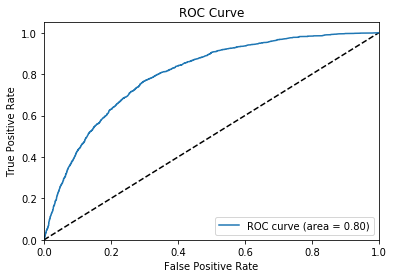

Tuned Hyperparameter(s): {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_split': 250}
Tuned Accuracy Score: 0.784522775598215
             precision    recall  f1-score   support

          0       0.81      0.93      0.87      6301
          1       0.61      0.35      0.44      2047

avg / total       0.76      0.78      0.76      8348



In [119]:
# Simple Random Forest Model

forest = RandomForestClassifier()
forest_param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": range(10,500,20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
train_and_test_model(X, y, forest, forest_param_grid)

### 3. 


In [130]:
best_model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=None, max_features=3, min_samples_split=250)
best_model.fit(X_train,y_train)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=250,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
feature_importances = pd.DataFrame(best_model.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
surge_pct,0.231881
avg_rating_by_driver,0.163502
avg_surge,0.131533
weekday_pct,0.095768
trips_in_first_30_days,0.064474
phone_Android,0.059444
ultimate_black_user,0.052570
city_King's Landing,0.047776
city_Astapor,0.040468
phone_iPhone,0.034663


In [ ]:
plot.bar(x='lab', y='val', rot=0)

In [138]:
list(feature_importances.index)

['surge_pct',
 'avg_rating_by_driver',
 'avg_surge',
 'weekday_pct',
 'trips_in_first_30_days',
 'phone_Android',
 'ultimate_black_user',
 "city_King's Landing",
 'city_Astapor',
 'phone_iPhone',
 'avg_dist',
 'avg_rating_of_driver',
 'city_Winterfell',
 'phone_Other']

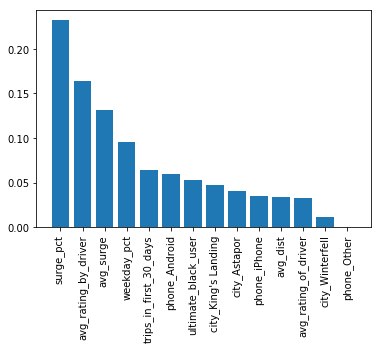

In [143]:
plt.bar(list(feature_importances.index),feature_importances['importance'])
plt.xticks(rotation=90);

In [150]:
display(df_ultimate['surge_pct'].corr(df_ultimate['active']))
display(df_ultimate['avg_rating_by_driver'].corr(df_ultimate['active']))
display(df_ultimate['avg_surge'].corr(df_ultimate['active']))
display(df_ultimate['weekday_pct'].corr(df_ultimate['active']))

0.01860084142252856

-0.02861128361766784

0.006766361870657551

-0.0035978475722542266